<a href="https://colab.research.google.com/github/AmeyaKI/lunar-navigation/blob/main/src/lunar_nav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import shutil

# **Data Preprocessing**

In [3]:
%pip install kagglehub --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.13
    Uninstalling kagglehub-0.3.13:
      Successfully uninstalled kagglehub-0.3.13


In [4]:
import kagglehub
dataset_path = kagglehub.dataset_download("romainpessia/artificial-lunar-rocky-landscape-dataset")

Using Colab cache for faster access to the 'artificial-lunar-rocky-landscape-dataset' dataset.


In [5]:
os.listdir(dataset_path)

['shadow_IDs.txt',
 'mismatch_IDs.txt',
 'ground_facing_IDs.txt',
 'images',
 'bounding_boxes.csv',
 'cam_anomaly_IDs.txt',
 'real_moon_images',
 'top200_largerocks_IDs.txt']

In [6]:
df = pd.read_csv(os.path.join(dataset_path, 'bounding_boxes.csv'))
len([img for img in os.listdir(os.path.join(dataset_path, 'images/render'))])

9766

In [7]:
# remove faulty images from dataset (October Kaggle update)
def remove_errors(dataset_path: str, df: pd.DataFrame):
    # compile list of faulty images
    txt_files = [i for i in os.listdir(dataset_path) if i.endswith('.txt')]
    faulty_images = []
    for txt in txt_files:
        with open(os.path.join(dataset_path, txt)) as file:
            for line in file:
                faulty_images.append(f"render{line.strip()}.png")

    print(len(faulty_images)) # 773 faulty images exist
    img_path = os.path.join(dataset_path, 'images/render')

    # removes faulty images from render folder
    def delete_images(img_path: str, faulty_images: list):
        data_images = [img for img in os.listdir(img_path) if img.endswith('.png')]
        for img in data_images:
            if img in faulty_images:
                os.remove(os.path.join(img_path, img))

    # removes rows of faulty images from dataframe
    def delete_boxes(df: pd.DataFrame, faulty_images: list):
        filtered_df = df[~df['Frame'].isin(faulty_image_nums)]
        return filtered_df
    faulty_image_nums = [int(i[6:10]) for i in faulty_images]

    delete_images(img_path, faulty_images)
    filtered_df = delete_boxes(df, faulty_image_nums)
    return filtered_df

In [8]:
# editable dataset path
writable_dataset_path = '/content/artificial-lunar-rocky-landscape-dataset_writable'

if os.path.exists(writable_dataset_path):
    shutil.rmtree(writable_dataset_path)

shutil.copytree(dataset_path, writable_dataset_path) # copy dataset to new path

'/content/artificial-lunar-rocky-landscape-dataset_writable'

In [9]:
# Before
print(len([img for img in os.listdir(os.path.join(dataset_path, 'images/render')) if img.endswith('.png')])) # num images
print(df.shape[0]) # num df-rows


filtered_df = remove_errors(writable_dataset_path, df)

# After
print(len([img for img in os.listdir(os.path.join(writable_dataset_path, 'images/render')) if img.endswith('.png')])) # num images
print(filtered_df.shape[0]) # num df-rows

9766
18867
773
8993
16819


Faulty images removed from dataset. Image dir and csv fully cleaned

In [10]:
filtered_df.to_csv(os.path.join(writable_dataset_path, 'filtered_bboxes.csv'), index=False)
os.listdir(writable_dataset_path)

['images',
 'mismatch_IDs.txt',
 'shadow_IDs.txt',
 'ground_facing_IDs.txt',
 'real_moon_images',
 'filtered_bboxes.csv',
 'cam_anomaly_IDs.txt',
 'top200_largerocks_IDs.txt',
 'bounding_boxes.csv']

# **Depth Estimation (MiDaS)**

In [11]:
import torch
import cv2

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
midas = torch.hub.load('intel-isl/MiDaS', "DPT_Hybrid")
midas.to(device)
midas.eval()

/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt


100%|██████████| 470M/470M [00:03<00:00, 152MB/s]


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): Identit

In [14]:
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = midas_transforms.dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [15]:
def load_image(image_path: str):
  image = cv2.imread(image_path)
  if image is None:
    raise ValueError(f'Failed to load {image_path}')
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return img

In [16]:
def predict_depth(image):
  input_batch = transform(image).to(device)

  with torch.no_grad():
    pred = midas(input_batch)

  pred = torch.nn.functional.interpolate(
      pred.unsqueeze(1),
      size=image.shape[:2],
      mode='bicubic',
      align_corners=False
  ).squeeze()

  depth = pred.cpu().numpy()
  return depth

In [17]:
def normalize_depth(depth):
    depth_min, depth_max = depth.min(), depth.max()

    if depth_max - depth_min < 1e-5: # arbtirary diff --> 0
      return np.zeros_like(depth)

    depth_norm = (depth - depth_min) / (depth_max - depth_min)
    return depth_norm

In [18]:
image_dir = Path(writable_dataset_path) / 'images' / 'render'
image_dir

PosixPath('/content/artificial-lunar-rocky-landscape-dataset_writable/images/render')

In [19]:
depth_dir = Path(writable_dataset_path) / 'images' / 'depth_maps'
depth_dir.mkdir(parents=True, exist_ok=True)

In [20]:
sorted_image_paths = sorted(image_dir.glob('*.png'))

In [21]:
from tqdm import tqdm # long computation absent gpu accl (currently using A100)
for image_path in tqdm(sorted_image_paths):
  image = load_image(image_path)
  depth = predict_depth(image)
  depth_norm = normalize_depth(depth)

  out_path = depth_dir / f"{image_path.stem}.npy"
  np.save(out_path, depth_norm)

100%|██████████| 8993/8993 [07:34<00:00, 19.79it/s]


In [22]:
os.listdir(Path(writable_dataset_path) / 'images')

['clean', 'render', 'depth_maps', 'ground']

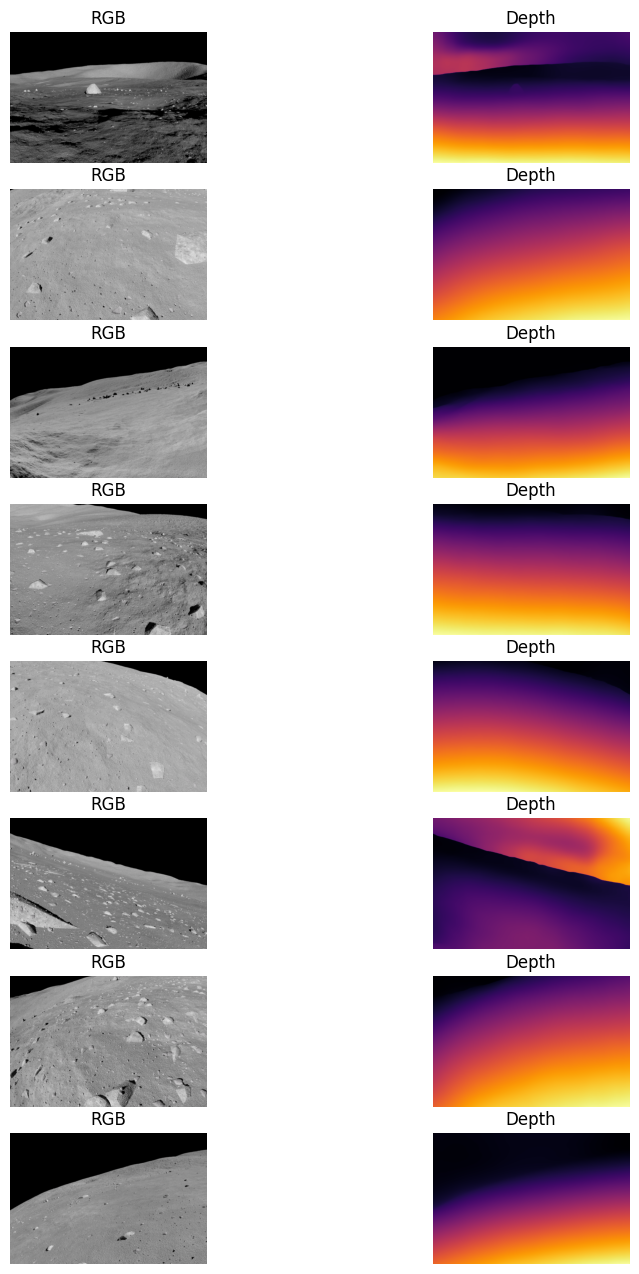

In [23]:
# verifying
import matplotlib.pyplot as plt
depth_files = sorted(depth_dir.glob('*.npy'))
fig, axes = plt.subplots(8, 2, figsize=(10, 16))

for i in range(8):
    img_path = image_dir / f"{depth_files[i].stem}.png"
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    depth = np.load(depth_files[i])

    axes[i, 0].imshow(img)
    axes[i, 0].set_title("RGB")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(depth, cmap="inferno")
    axes[i, 1].set_title("Depth")
    axes[i, 1].axis("off")

# **Rock Geometry Model (WORK IN PROG) **


In [24]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torch.nn as nn

Objective: Predict
1. relative height of rock above ground
2. relative size of rock
3. relative distance from hopper rover

In [25]:
def compute_relative_height(depth, bbox, ring=8):
    x1, y1, x2, y2 = bbox

    rock_depth = np.median(depth[y1:y2, x1:x2])

    y1g = max(0, y1 - ring)
    y2g = min(depth.shape[0], y2 + ring)
    x1g = max(0, x1 - ring)
    x2g = min(depth.shape[1], x2 + ring)

    ground_mask = np.ones((y2g - y1g, x2g - x1g), dtype=bool)
    ground_mask[(y1 - y1g):(y2 - y1g), (x1 - x1g):(x2 - x1g)] = False

    ground_depth = np.median(depth[y1g:y2g, x1g:x2g][ground_mask])

    return ground_depth - rock_depth

In [26]:
def compute_relative_size(bbox, img_shape):
    x1, y1, x2, y2 = bbox
    box_area = (x2 - x1) * (y2 - y1)
    img_area = img_shape[0] * img_shape[1]
    return box_area / img_area

In [27]:
def compute_relative_distance(depth, bbox):
    x1, y1, x2, y2 = bbox
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2
    return depth[cy, cx]

In [28]:
df_path = os.path.join(writable_dataset_path, 'filtered_bboxes.csv')
image_path = os.path.join(writable_dataset_path, 'images/render')
depth_path = os.path.join(writable_dataset_path, 'images/depth_maps')

In [29]:
class RockDataset(Dataset):
    def __init__(self, df, image_dir, depth_dir):
        self.df = df # bounding boxes csv
        self.image_dir = image_dir # image
        self.depth_dir = depth_dir # depth map

        self.groups = self.df.groupby("Frame")
        self.index = []
        for frame, group in self.groups:
            for i in range(len(group)):
                self.index.append((frame, i))

        self.rgb_tf = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        self.depth_tf = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224))
        ])

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        frame, box_idx = self.index[idx]
        group = self.groups.get_group(frame).iloc[box_idx]

        img_path = os.path.join(self.image_dir, f"render{str(frame).zfill(4)}.png")
        depth_path = os.path.join(self.depth_dir, f"render{str(frame).zfill(4)}.npy")

        rgb_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        depth = np.load(depth_path)

        x1 = int(group['TopLeftCornerX'])
        y1 = int(group['TopLeftCornerY'])
        x2 = x1 + int(group['Length'])
        y2 = y1 + int(group['Height'])

        assert x2 > x1 and y2 > y1, "Invalid bbox coordinates"

        rgb_box = rgb_img[y1:y2, x1:x2]
        depth_box = depth[y1:y2, x1:x2]

        rel_height = compute_relative_height(depth, (x1, y1, x2, y2))
        rel_distance = compute_relative_distance(depth, (x1, y1, x2, y2))
        rel_size = compute_relative_size(
            (x1, y1, x2, y2), rgb_img.shape
        )

        meta = torch.tensor([
            (x2 - x1) / rgb_img.shape[1],  # relative width
            (y2 - y1) / rgb_img.shape[0],  # relative height
            rel_size
        ], dtype=torch.float32)

        target = torch.tensor(
            [rel_distance, rel_height, rel_size], # distance then height then size!
            dtype=torch.float32
        )

        return (
            self.rgb_tf(rgb_box),
            self.depth_tf(depth_box),
            meta,
            target
        )

In [30]:
# Geometry Learning CNN
class RockGeometricCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # RGB
    self.rgb_encoder = torchvision.models.resnet18(pretrained=True) # ResNet outputs 512f
    self.rgb_encoder.fc = nn.Identity()

    # Depth
    self.depth_encoder = torchvision.models.resnet18(pretrained=True)
    self.depth_encoder.conv1 = nn.Conv2d(in_channels=1,
                                         out_channels=64,
                                         kernel_size=7,
                                         stride=2,
                                         padding=3,
                                         bias=False
                                         )
    self.depth_encoder.fc = nn.Identity()

    # MLP/meta
    self.meta_mlp = nn.Sequential(
        nn.Linear(in_features=3,
                  out_features=32), # tbd
        nn.ReLU()
    )

    # reg
    self.reg_head = nn.Sequential(
        nn.Linear(in_features=512+512+32,
                  out_features=128), # tbd
        nn.ReLU(),
        nn.Linear(in_features=128,
                  out_features=3)
    )

  def forward(self, rgb, depth, meta):
    rgb_features = self.rgb_encoder(rgb)
    depth_features = self.depth_encoder(depth)
    meta_features = self.meta_mlp(meta)

    x = torch.cat([rgb_features, depth_features, meta_features], dim=1)
    return self.reg_head(x)

In [31]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(df_path)

frames = df['Frame'].unique()

train_frames, test_frames = train_test_split(
    frames,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_df = df[df['Frame'].isin(train_frames)].reset_index(drop=True)
test_df  = df[df['Frame'].isin(test_frames)].reset_index(drop=True)

In [32]:
train_dataset = RockDataset(train_df, image_path, depth_path)
test_dataset  = RockDataset(test_df, image_path, depth_path)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [33]:
model = RockGeometricCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 246MB/s]


In [34]:
# Train
def train(model, train_loader: DataLoader, device, epoch_count=20):
  model.train()
  total_loss = 0.0

  for epoch in range(epoch_count): # 20 epochs
    for rgb, depth, meta, target in train_loader:
      rgb, depth, meta = rgb.to(device), depth.to(device), meta.to(device)
      target = target.to(device)

      pred = model(rgb, depth, meta) # model prediction
      loss = loss_fn(pred, target) # loss...

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f"Epoch {epoch}: Loss: {total_loss / len(train_loader):.4f}")

Errors:

MAE - how far off are estimates (true-pred size, true-pred height, true-pred dist)

MSE - how large are errors of estimates squared


In [35]:
def test(model, test_loader: DataLoader, device):
  model.eval()

  mse_total, mae_total = 0.0, 0.0
  dist_mse, height_mse, size_mse = 0.0, 0.0, 0.0
  dist_mae, height_mae, size_mae = 0.0, 0.0, 0.0

  all_preds, all_targets = [], []

  with torch.no_grad():
    for rgb, depth, meta, target in test_loader:
      rgb, depth, meta = rgb.to(device), depth.to(device), meta.to(device)
      target = target.to(device)

      pred = model(rgb, depth, meta)
      all_preds.append(pred.cpu())
      all_targets.append(target.cpu())

      # total errors
      mse_total += torch.mean((pred - target) **2).item()
      mae_total += torch.mean(torch.abs(pred - target)).item()

      # Dist errors
      dist_mse += torch.mean((pred[:, 0] - target[:, 0]) ** 2).item()
      dist_mae += torch.mean(torch.abs(pred[:, 0] - target[:, 0])).item()

      # height errors
      height_mse += torch.mean((pred[:, 1] - target[:, 1]) ** 2).item()
      height_mae += torch.mean(torch.abs(pred[:, 1] - target[:, 1])).item()

      # size errors
      size_mse += torch.mean((pred[:, 2] - target[:, 2]) ** 2).item()
      size_mae += torch.mean(torch.abs(pred[:, 2] - target[:, 2])).item()

  length = len(test_loader)
  metrics = {
      'total_mse': f'{mse_total / length:.4f}',
      'total_mae': f'{mae_total / length:.4f}',

      'dist_mse': f'{dist_mse / length:.4f}',
      'dist_mae': f'{dist_mae / length:.4f}',

      'height_mse': f'{height_mse / length:.4f}',
      'height_mae': f'{height_mae / length:.4f}',

      'size_mse': f'{size_mse / length:.4f}',
      'size_mae': f'{size_mae / length:.4f}'
  }
  total_preds = torch.cat(all_preds)
  total_targets = torch.cat(all_targets)

  return metrics, total_preds, total_targets
  print("OVERALL METRICS")
  print(f"Total MSE: {mse_total / length:.4f}")
  print(f"Total MAE: {mae_total / length:.4f}")

  print("PER-DIMENSION METRICS")
  print(f"Distance  MSE: {dist_mse / length:.4f}    MAE: {dist_mae / length:.4f}")
  print(f"Height    MSE: {height_mse / length:.4f}  MAE: {height_mae / length:.4f}")
  print(f"Size      MSE: {size_mse / length:.4f}    MAE: {size_mae / length:.4f}")

In [36]:
train(model, train_loader, device, 5)

Epoch 0: Loss: 0.0048
Epoch 1: Loss: 0.0058
Epoch 2: Loss: 0.0066
Epoch 3: Loss: 0.0075
Epoch 4: Loss: 0.0083


In [37]:
metrics, total_preds, total_targets = test(model, test_loader, device)

In [38]:
print("EVAL METRICS")
for metric, value in metrics.items():
  print(f"{metric}: {value}")

EVAL METRICS
total_mse: 0.0004
total_mae: 0.0135
dist_mse: 0.0005
dist_mae: 0.0176
height_mse: 0.0007
height_mae: 0.0150
size_mse: 0.0001
size_mae: 0.0078


Post-Train-Test Evaluation

In [39]:
def plot_results(total_preds, total_targets, dim, label):
  preds_dim = total_preds[:, dim].numpy()
  targets_dim = total_targets[:, dim].numpy()

  plt.figure(figsize=(6,6))
  plt.scatter(targets_dim, preds_dim, alpha=0.5)

  min_v = min(targets_dim.min(), preds_dim.min())
  max_v = max(targets_dim.max(), preds_dim.max())
  plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")

  plt.xlabel(f"Actual {label}")
  plt.ylabel(f"Predicted {label}")
  plt.title(f"{label}: Predicted vs Actual")
  plt.grid(True)
  plt.show()

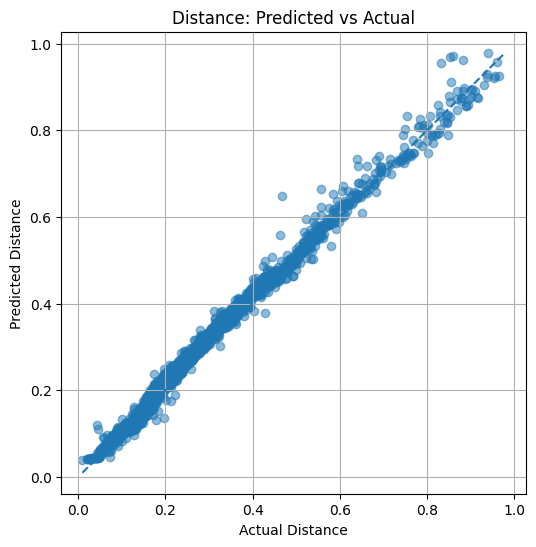

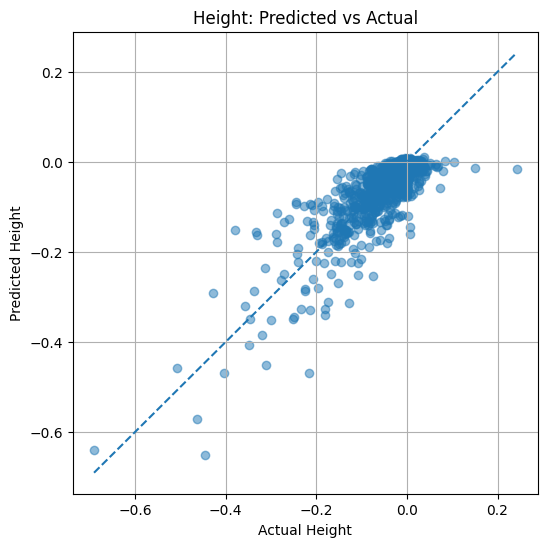

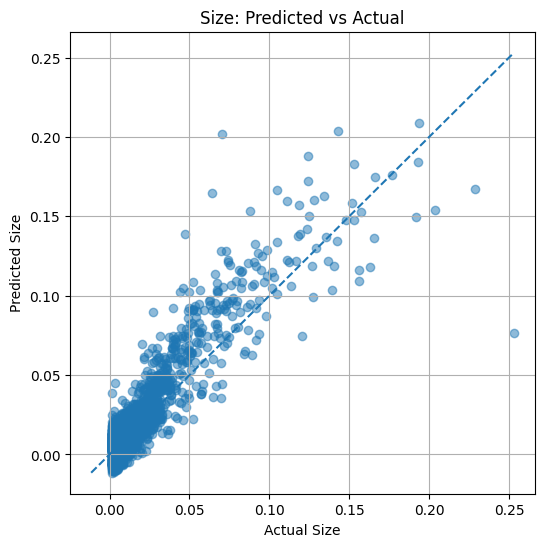

In [40]:
dim_value_dict = {0: "Distance", 1: "Height", 2: "Size"}
for dim, label in dim_value_dict.items():
  plot_results(total_preds, total_targets, dim, label)